# Transformer emotion recognizer

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the emotion dataset.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.1 MB/s eta 0:00:00


Import modules and set random seeds.

In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Download the emotion dataset and check the maximum text length.

In [4]:
from datasets import load_dataset
emotions = load_dataset('emotion')
max_textlen = max(
    [len(text.split(' '))
     for text in emotions['train']['text'] + emotions['validation']['text']])
print('Maximum text length: {}'.format(max_textlen))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Maximum text length: 66


Create the training and test datasets.

In [5]:
MAX_LEN = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_mask = np.array(train_set['attention_mask'])
train_label = np.eye(6)[emotions['train']['label']]

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_mask = np.array(test_set['attention_mask'])
test_label = np.eye(6)[emotions['validation']['label']]

emotion_labels = emotions['train'].features['label'].names

Define the positional embedding layer.

In [6]:
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(Embeddings, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=max_len,
                                        output_dim=embed_dim)
        self.dropout = layers.Dropout(rate=0.5)
        self.ln = layers.LayerNormalization(epsilon=1e-12)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)

        token_embeddings = self.token_emb(inputs)
        embeddings = token_embeddings + position_embeddings # Add positional embeddings

        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

Dfiner the Transformer encoder block.

In [7]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, masks):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        attention_mask = tf.reshape(
            tf.tile(masks, [1, seq_len]), [batch_size, seq_len, seq_len])
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=attention_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        attention_output = attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)

        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
            }
        )
        return config

Define the text classification model consisted of two Transformer encoder blocks.

In [8]:
EMBEDDING_DIM = 512
N_HEADS = 4
KEY_DIM = EMBEDDING_DIM // N_HEADS
FEED_FORWARD_DIM = 2048

text_inputs = layers.Input(shape=(None,), dtype=tf.int32)
mask_inputs = layers.Input(shape=(None,), dtype=tf.int32)

x = Embeddings(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(text_inputs)
x, attention_scores1 = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x, mask_inputs)
x, attention_scores2 = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x, mask_inputs)
output = layers.Dense(6, activation='softmax')(x[:, 0, :]) # select [CLS] token

# Model for training and prediction
transformer_model = models.Model(
    inputs=[text_inputs, mask_inputs], outputs=output)

# Model for inference including attention scores
attention_scores_model = models.Model(
    inputs=[text_inputs, mask_inputs],
    outputs=[output, attention_scores1, attention_scores2])

transformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embeddings (Embeddings)        (None, None, 512)    15693824    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 transformer_block (Transformer  ((None, None, 512),  3152384    ['embeddings[0][0]',             
 Block)                          (None, 4, None, No               'input_2[0][0]']            

Compile the model using the Adam optimizer, and the categorical crossentroy as a loss function.

In [9]:
transformer_model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                          loss='categorical_crossentropy',
                          metrics=['acc'])

Train the model. It achieves around 90% accuracy.

In [10]:
%%time
history = transformer_model.fit([train_text, train_mask], train_label,
                                 validation_data=([test_text, test_mask], test_label),
                                 batch_size=32, epochs=8)

Epoch 1/8
500/500 [==============================] - 77s 119ms/step - loss: 1.6467 - acc: 0.3443 - val_loss: 1.1866 - val_acc: 0.5700
Epoch 2/8
500/500 [==============================] - 39s 79ms/step - loss: 0.7754 - acc: 0.7297 - val_loss: 0.3346 - val_acc: 0.8730
Epoch 3/8
500/500 [==============================] - 36s 72ms/step - loss: 0.4081 - acc: 0.8611 - val_loss: 0.2683 - val_acc: 0.8975
Epoch 4/8
500/500 [==============================] - 35s 70ms/step - loss: 0.3244 - acc: 0.8834 - val_loss: 0.2504 - val_acc: 0.8930
Epoch 5/8
500/500 [==============================] - 36s 73ms/step - loss: 0.2763 - acc: 0.8967 - val_loss: 0.2458 - val_acc: 0.8950
Epoch 6/8
500/500 [==============================] - 35s 70ms/step - loss: 0.2456 - acc: 0.9053 - val_loss: 0.2328 - val_acc: 0.9020
Epoch 7/8
500/500 [==============================] - 36s 72ms/step - loss: 0.2173 - acc: 0.9136 - val_loss: 0.2357 - val_acc: 0.9000
Epoch 8/8
500/500 [==============================] - 35s 71ms/step -

Plot charts for the accuracy and loss values.

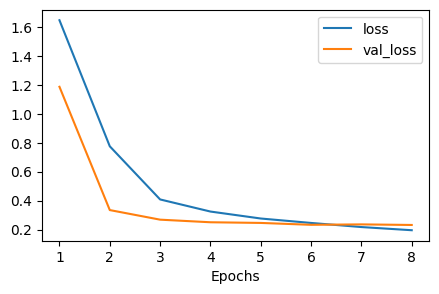

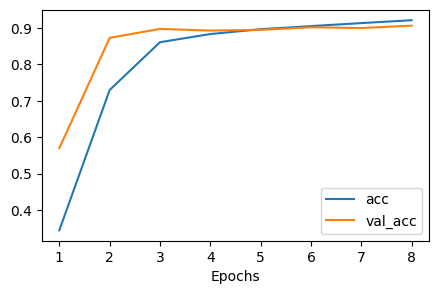

In [11]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Show the confusion matrix against the test set.

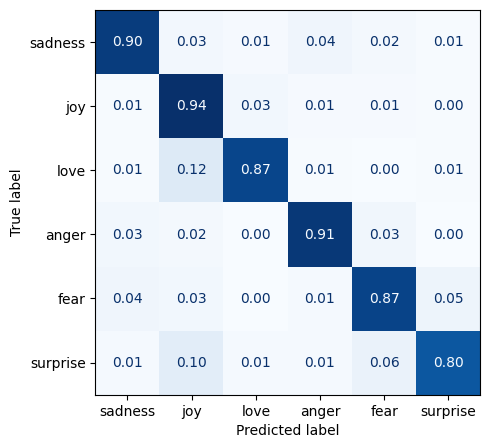

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = transformer_model.predict([test_text, test_mask], verbose=0)

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

Show predictions for some sample texts.

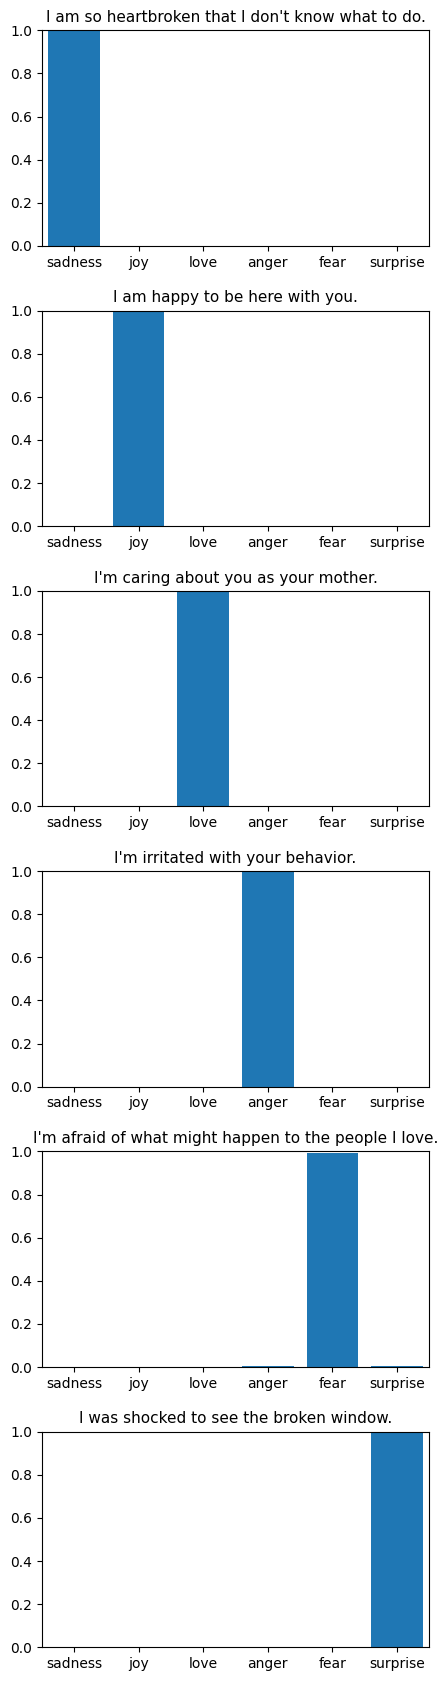

In [13]:
input_text = [
    "I am so heartbroken that I don't know what to do.",
    "I am happy to be here with you.",
    "I'm caring about you as your mother.",
    "I'm irritated with your behavior.",
    "I'm afraid of what might happen to the people I love.",
    "I was shocked to see the broken window."]

tokenized_text = tokenizer(input_text, max_length=MAX_LEN,
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
mask = np.array(tokenized_text['attention_mask'])

predictions = transformer_model.predict([input_ids, mask], verbose=0)

n = len(predictions)
fig = plt.figure(figsize=(5, 3.5 * n))
plt.subplots_adjust(hspace=0.3)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(n, 1, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')

Show attention weights (averaged over multiple attention heads) for two Transformer encoder layers.

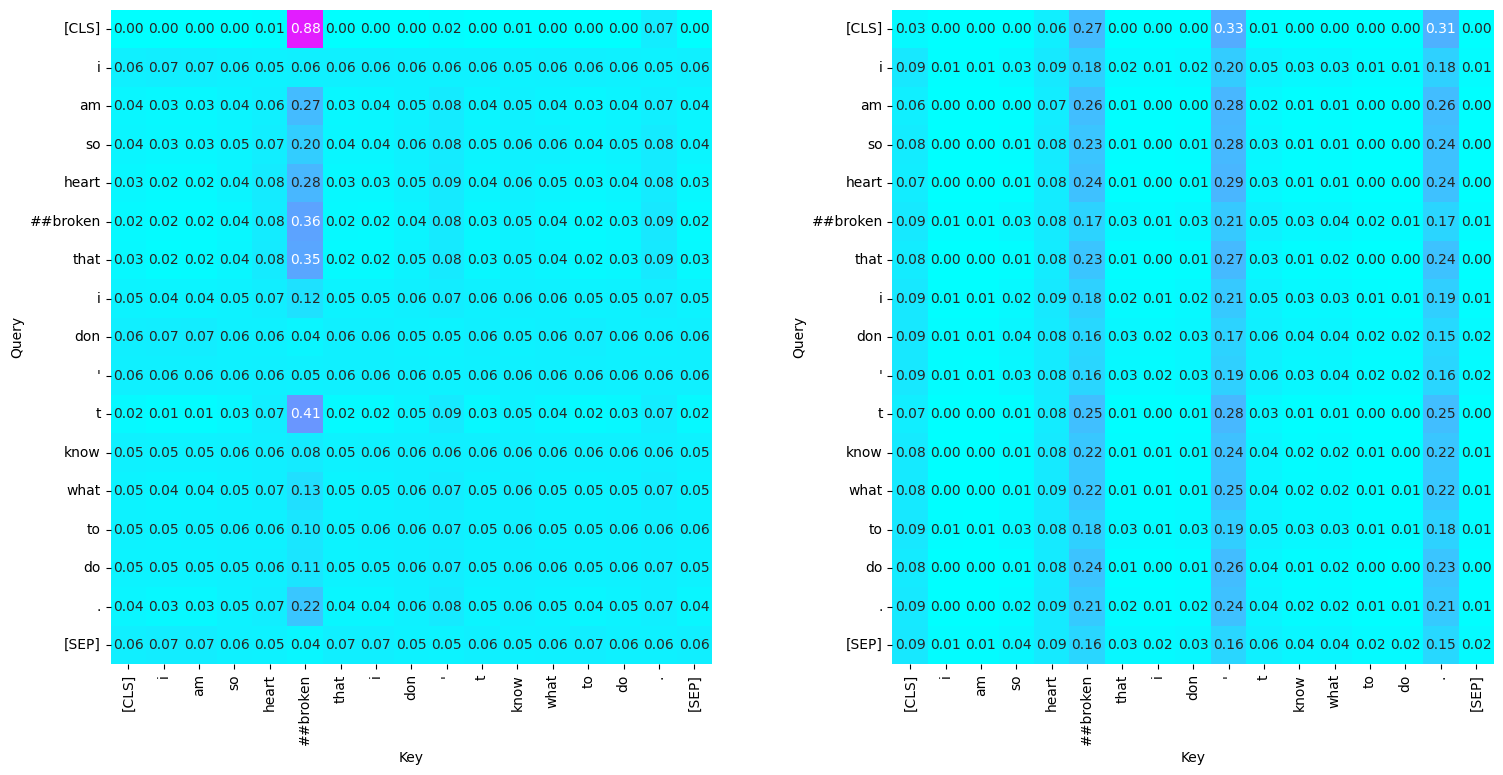

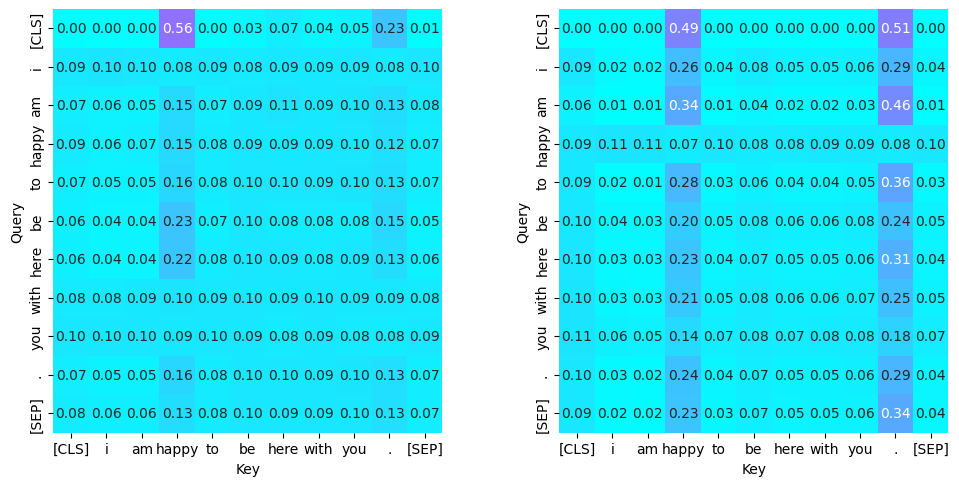

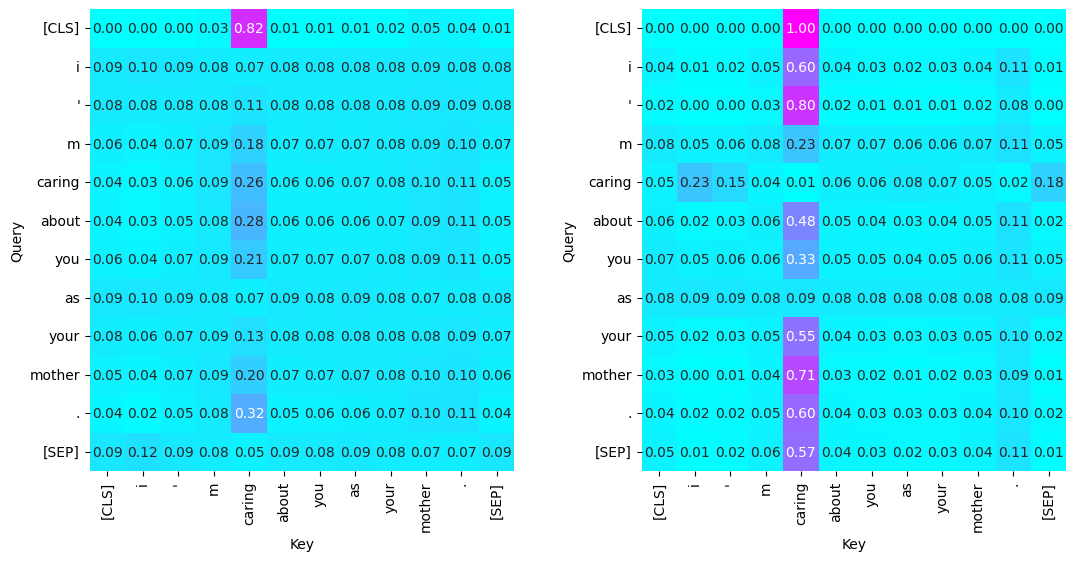

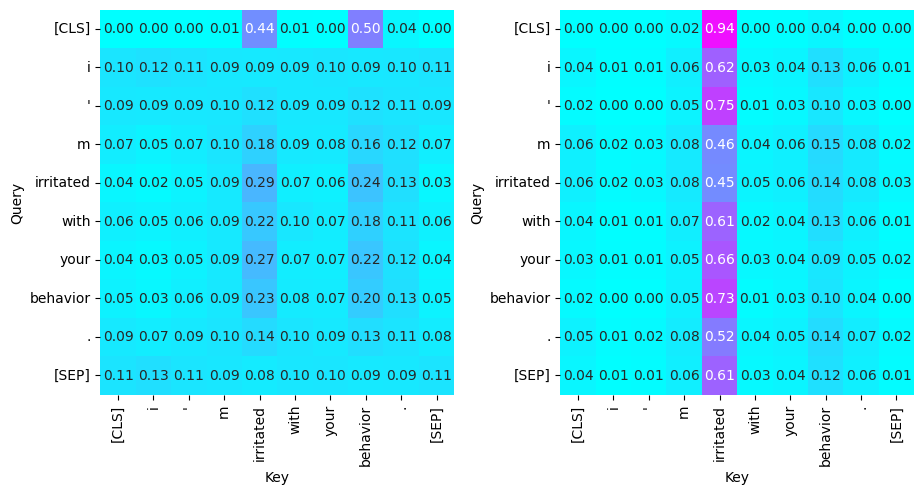

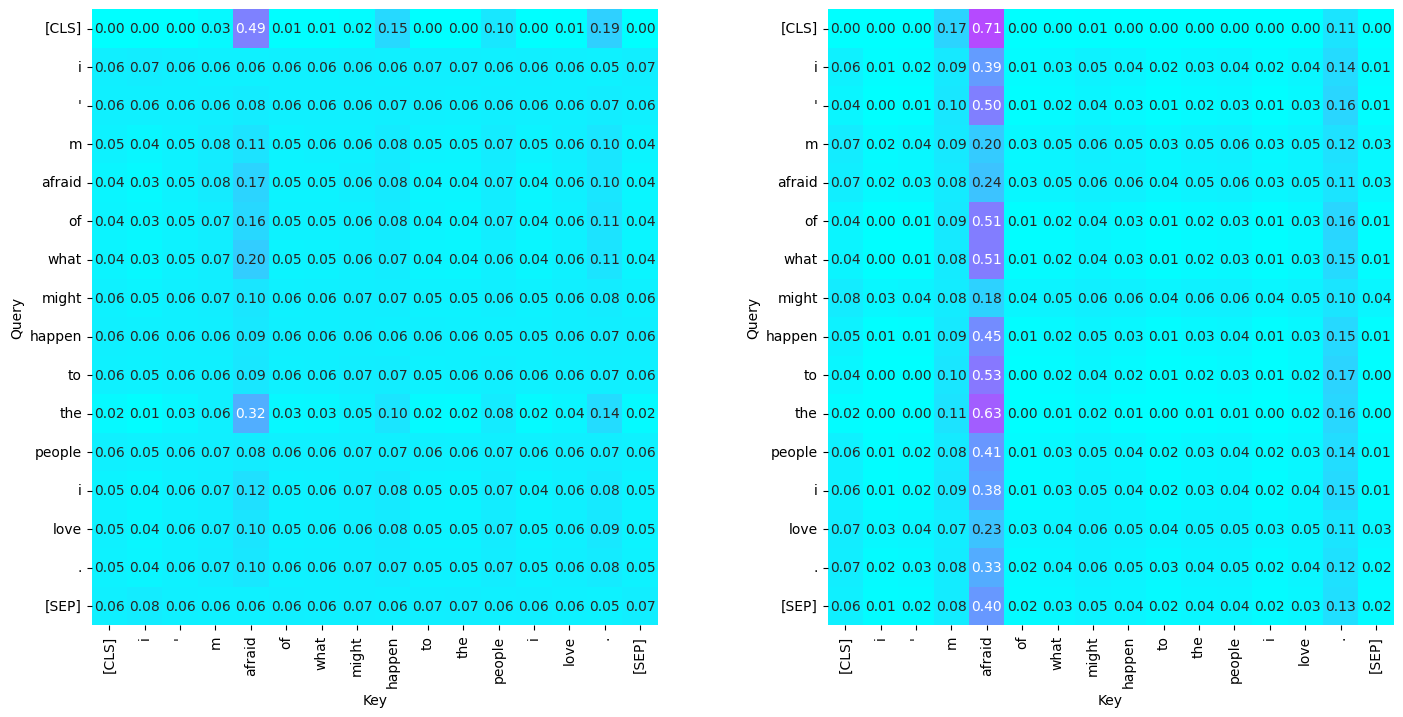

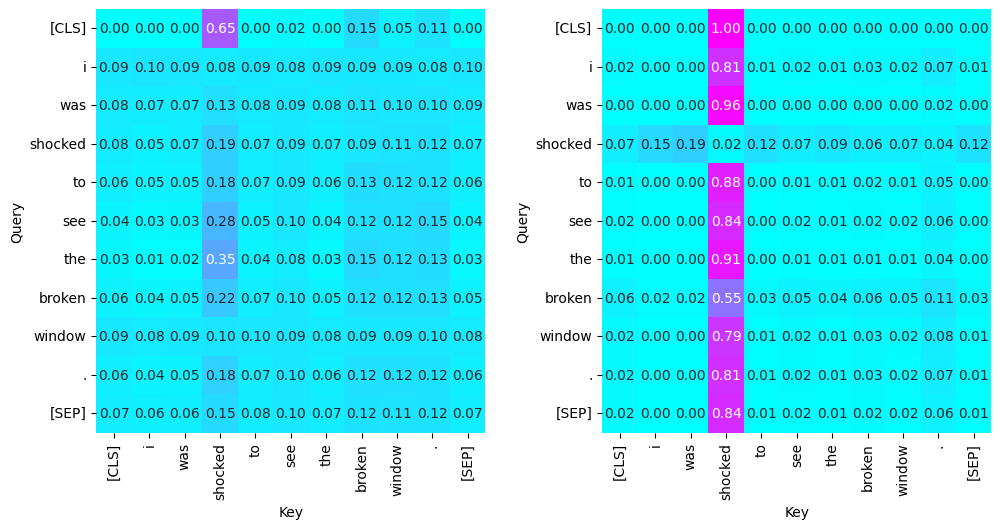

In [14]:
import seaborn as sns

pred, attention_scores1, attention_scores2 = attention_scores_model.predict([input_ids, mask], verbose=0)

for c, text in enumerate(input_text):
    labels = tokenizer.convert_ids_to_tokens(input_ids[c])
    text_len = sum(mask[c])
    fig = plt.figure(figsize=(text_len*1.05, text_len/2))
    fig.subplots_adjust(hspace=0, wspace=0.3)
    subplot = fig.add_subplot(1, 2, 1)
    heatmap = sns.heatmap(np.mean(attention_scores1[c, :, :text_len, :text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[:text_len], yticklabels=labels[:text_len],
                    cmap='cool', vmin=0, vmax=1, cbar=False,
                    annot=True, fmt='1.2f')
    _ = heatmap.set(xlabel='Key', ylabel='Query')
    subplot = fig.add_subplot(1, 2, 2)
    heatmap = sns.heatmap(np.mean(attention_scores2[c, :, :text_len, :text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[:text_len], yticklabels=labels[:text_len],
                    cmap='cool', vmin=0, vmax=1, cbar=False,
                    annot=True, fmt='1.2f')
    _ = heatmap.set(xlabel='Key', ylabel='Query')